In [3]:
from xbbg import blp
import pdblp
import workdays
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 70)
plt.rcParams['font.family'] = 'Meiryo'


In [4]:
def BDP(T):
    BDP = blp.bdp(tickers=T, flds=['name','currency','exch_code','undl_spot_ticker']).loc[T,:]
    BDP = BDP.reset_index(drop=True)
    tmp = []
    for i in range(len(T)):
        tmp  += [(blp.bdh(T[i], 'px_last', '19991201', '20220101', Per='M' ).reset_index().iloc[0,0]).strftime('%Y%m%d')]
    BDP['initinal_t/d'] = tmp
    BDP = BDP.replace('19991231', '-')
    return BDP

def BDH(T):
    BDH = blp.bdh(T, ['px_last','tot_return_index_gross_dvds'], d_from, d_to, Calendar='5D', Fill='P' ).reset_index()   
    T1 = ['USDJPY BGN Curncy','SBUS13L Index','SBUS13YC Index']
    BDH1 = blp.bdh(T1, 'px_last', d_from, d_to, Calendar='5D', Fill='P' ).reset_index()
    
    df = pd.DataFrame(BDH['index'].values,columns = ['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = ME(df)
    
    for i in range(len(T0)):
        df[T0[i]+'_PR'] = BDH[T[i]]['px_last'].pct_change()
        df[T0[i]+'_TR'] = BDH[T[i]]['tot_return_index_gross_dvds'].pct_change()
        df[T0[i]+'_NR'] = ( df[T0[i]+'_TR'] - df[T0[i]+'_PR'] ) * ( 1 - tax) + df[T0[i]+'_PR']
        
        for j in ['PR','TR','NR']:
            df[T0[i]+'_'+j+'_Index'] = (1 + df[T0[i]+'_'+j] ).cumprod().fillna(1) * 100

    df['USDJPY'] = BDH1['USDJPY BGN Curncy'].pct_change() 
    df['USDJPY_FP'] = BDH1['SBUS13L Index'].pct_change() - BDH1['SBUS13YC Index'].pct_change()
    df['USDJPY_CR'] = df['USDJPY'] + df['USDJPY_FP']
    return df


def ME(df):
    df['ME'] = 0
    tmp = df['Date'].dt.month != df['Date'].shift(-1).dt.month
    df['ME'] = np.where(tmp & (df['Date'].dt.month == 3), 3, np.where(tmp, 1, 0))
    df.loc[len(df)-1, 'ME'] = 3
    return df

def Plot2(title,tmp,color2='tab:orange'):
    print( 'Return', round((df['Date'][len(df)-1] - df['Date'][0] ).days / 365.25 ,1),'Year')
    for i in tmp:
        tmp1 = df[i+'_Index'][len(df)-1] / df[i+'_Index'][0] - 1
        print(i+':', round(tmp1,3) )
    
    c1, c2 = [ i + '_Index' for i in tmp]
    l1, l2 = tmp
    fig, ax = plt.subplots(figsize=(6.5, 2))
    ax.plot(df['Date'], df[c1], label=l1)
    ax.plot(df['Date'], df[c2], label=l2, color=color2)
    ax.set_title(title, fontsize=10)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [5]:
T = ['SPY US Equity','ES1 Index','BIL US Equity']
T0 = ['SPY','ES1','BIL']
BDP(T)

,name,currency,exch_code,initinal_t/d
0,SPDR S&P 500 ETF TRUST,USD,US,-
1,Generic 1st 'ES' Future,USD,CME,-
2,SPDR BLOOMBERG 1-3 MONTH T-B,USD,US,20070531


In [6]:
d_from = '20200301'
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime('%Y%m%d')
tax = 0.1
df = BDH(T)
df.head()

,Date,ME,SPY_PR,SPY_TR,SPY_NR,SPY_PR_Index,SPY_TR_Index,SPY_NR_Index,ES1_PR,ES1_TR,ES1_NR,ES1_PR_Index,ES1_TR_Index,ES1_NR_Index,BIL_PR,BIL_TR,BIL_NR,BIL_PR_Index,BIL_TR_Index,BIL_NR_Index,USDJPY,USDJPY_FP,USDJPY_CR
0,2020-03-02,0,NaN,NaN,NaN,100.000000,100.000000,100.000000,NaN,NaN,NaN,100.000000,100.000000,100.000000,NaN,NaN,NaN,100.000000,100.000000,100.000000,NaN,NaN,NaN
1,2020-03-03,0,-0.028632,-0.028632,-0.028632,97.136756,97.136756,97.136756,-0.022186,-0.022186,-0.022186,97.781403,97.781403,97.781403,0.000219,0.000218,0.000218,100.021865,100.021842,100.021844,-0.011077,0.000063,-0.011014
2,2020-03-04,0,0.042033,0.042033,0.042033,101.219709,101.219709,101.219709,0.039291,0.039291,0.039291,101.623325,101.623325,101.623325,0.000437,0.000438,0.000438,100.065595,100.065635,100.065631,0.003734,0.000070,0.003804
3,2020-03-05,0,-0.033242,-0.033242,-0.033242,97.854994,97.854994,97.854994,-0.031867,-0.031867,-0.031867,98.384894,98.384894,98.384894,0.000219,0.000218,0.000218,100.087460,100.087477,100.087475,-0.012741,0.000092,-0.012649
4,2020-03-06,0,-0.016531,-0.016531,-0.016531,96.237342,96.237342,96.237342,-0.017078,-0.017078,-0.017078,96.704665,96.704665,96.704665,0.000000,0.000000,0.000000,100.087460,100.087477,100.087475,-0.007253,0.000158,-0.007095


Return 3.9 Year
SPY_NR: 0.67
ES1+BIL_NR: 0.65


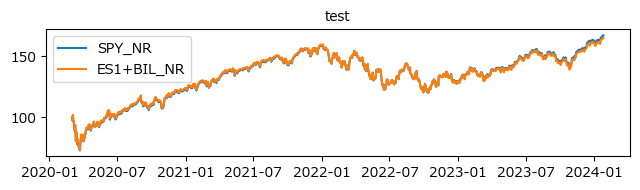

In [7]:
tmp = ['SPY_NR','ES1+BIL_NR']
df[tmp[1]] = df['ES1_NR'] + df['BIL_NR']
df[tmp[1]+'_Index'] = (1 + df[tmp[1]]).cumprod().fillna(1) * 100

Plot2('test',tmp,color2='tab:orange')

Return 3.9 Year
SPY_NR+JPY: 1.284
ES1+JPY_CR: 1.336


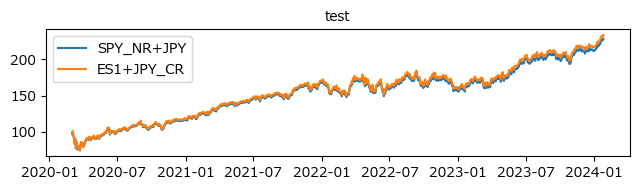

In [8]:
tmp = ['SPY_NR+JPY','ES1+JPY_CR']


df[tmp[0]] = (1+df['SPY_NR'])*(1+ df['USDJPY'])-1
df[tmp[0]+'_Index'] = (1 + df[tmp[0]]).cumprod().fillna(1) * 100

df[tmp[1]] = (1+df['ES1_NR'])*(1+ df['USDJPY_CR'])-1
df[tmp[1]+'_Index'] = (1 + df[tmp[1]]).cumprod().fillna(1) * 100

Plot2('test',tmp,color2='tab:orange')